In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [2]:
!pwd

/home/jwillow/Documents/UofT/MIE1628/notebook


In [3]:
train_features = './lish-moa/train_features.csv'
train_labels = './lish-moa/train_targets_scored.csv'

test_features = './lish-moa/test_features.csv'
test_labels = './lish-moa/train_targets_nonscored.csv'

train_features_df = pd.read_csv(
    filepath_or_buffer = train_features,
    sep=',',
    delimiter=None,
    header='infer',
    index_col='sig_id',
)

train_labels_df = pd.read_csv(
    filepath_or_buffer = train_labels,
    sep=',',
    delimiter=None,
    header='infer',
    index_col='sig_id',
)

Data-Process: Checking for data types

In [4]:
print('Train features dimensions: ', train_features_df.shape)
total_nans = train_features_df.isnull().sum().sum()
print('Number of NULL values: ', total_nans)

# train_features_df['cp_type'].dtype
numeric_cols = train_features_df.dtypes[train_features_df.dtypes != "object"].index.tolist() 
categorical_cols = train_features_df.dtypes[train_features_df.dtypes == "object"].index.tolist()

print(f'{len(numeric_cols)} numeric columns and {len(categorical_cols)} categoical columns')

Train features dimensions:  (23814, 875)
Number of NULL values:  0
873 numeric columns and 2 categoical columns


### Data Process - check cp_type, drop rows where cp_type == ctl_vehicle

In [5]:
# train_features_df[train_features_df['cp_type']=='ctl_vehicle']
'''
Label-based indexing. Check the activation of MoI for trt_cp type 

can use this to plot the distribution plot for different cp_types
'''
index_for_trt_cp_type = train_features_df[train_features_df['cp_type']=='trt_cp'].index
trt_cp_label_df = train_labels_df.loc[index_for_trt_cp_type]
trt_cp_label_df.sum()

index_for_ctl_cp_type = train_features_df[train_features_df['cp_type']=='ctl_vehicle'].index
ctl_cp_label_df = train_labels_df.loc[index_for_ctl_cp_type]
ctl_cp_label_df.sum().sum()

print('If cp_type==ctl_vehicle, there is no MoI activation')

# Drop the rows with cp_type = ctl_vehicle
train_features_df = train_features_df[train_features_df['cp_type']=='trt_cp']
train_features_df.drop(labels='cp_type', axis=1, inplace=True)
train_labels_df = train_labels_df.loc[index_for_trt_cp_type]

If cp_type==ctl_vehicle, there is no MoI activation


### Data-Process: Distribution of MoI for cp_dose D1 vs D2

In [6]:
'''
Two series that capture the different distribution of CP_dose feature -> Data Visualization
'''
index_for_d1_cp_dose = train_features_df[train_features_df['cp_dose']=='D1'].index
d1_dose_label_df = train_labels_df.loc[index_for_trt_cp_type]
d1_dose_label_df.sum()

index_for_d2_cp_dose = train_features_df[train_features_df['cp_dose']=='D2'].index
d2_dose_label_df = train_labels_df.loc[index_for_trt_cp_type]
d2_dose_label_df.sum()

5-alpha_reductase_inhibitor               17
11-beta-hsd1_inhibitor                    18
acat_inhibitor                            24
acetylcholine_receptor_agonist           190
acetylcholine_receptor_antagonist        301
                                        ... 
ubiquitin_specific_protease_inhibitor      6
vegfr_inhibitor                          170
vitamin_b                                 26
vitamin_d_receptor_agonist                39
wnt_inhibitor                             30
Length: 206, dtype: int64

### Encode categoricals to 1's and 0's

In [7]:
le = LabelEncoder()
categorical_cols.remove('cp_type')
train_features_df[categorical_cols] = train_features_df[categorical_cols].apply(lambda col: le.fit_transform(col))
train_features_df[categorical_cols].head(10)

,cp_dose
sig_id,
id_000644bb2,0
id_000779bfc,0
id_000a6266a,0
id_0015fd391,0
id_001626bd3,1
id_001762a82,0
id_001bd861f,1
id_0020d0484,0
id_00224bf20,0


### Data-Process: Standardize Feature data

In [8]:
scaler = StandardScaler()

for num_col in numeric_cols:
    train_features_df[num_col] = scaler.fit_transform(np.array(train_features_df[num_col]).reshape(-1,1))

In [9]:
# train_features_df
# train_labels_df

# train_features_df = train_features_df[0:10000]
# train_labels_df = train_labels_df[0:10000]

In [10]:
# dt = DecisionTreeClassifier(
#     criterion='gini',
#     splitter='best',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features=None,
#     random_state=None,
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     class_weight=None,
#     presort='deprecated',
#     ccp_alpha=0.0,
# )
# dt.fit(train_features_df, train_labels_df)


In [11]:
# feature_importance = dt.feature_importances_

# ranked_importance = np.argsort(feature_importance)
# ranked_importance_ind = ranked_importance[::-1] # Descending order
# ranked_importance_val = feature_importance[ranked_importance_ind]
# np.save(file='dt_feature_importance_ranked_value', arr=ranked_importance_val)
# np.save(file='dt_feature_importance_ranked_ind', arr=ranked_importance_ind)

In [12]:
dt_feature_importance_ind = np.load(file='dt_feature_importance_ranked_ind.npy')
dt_feature_importance_val = np.load(file='dt_feature_importance_ranked_value.npy')

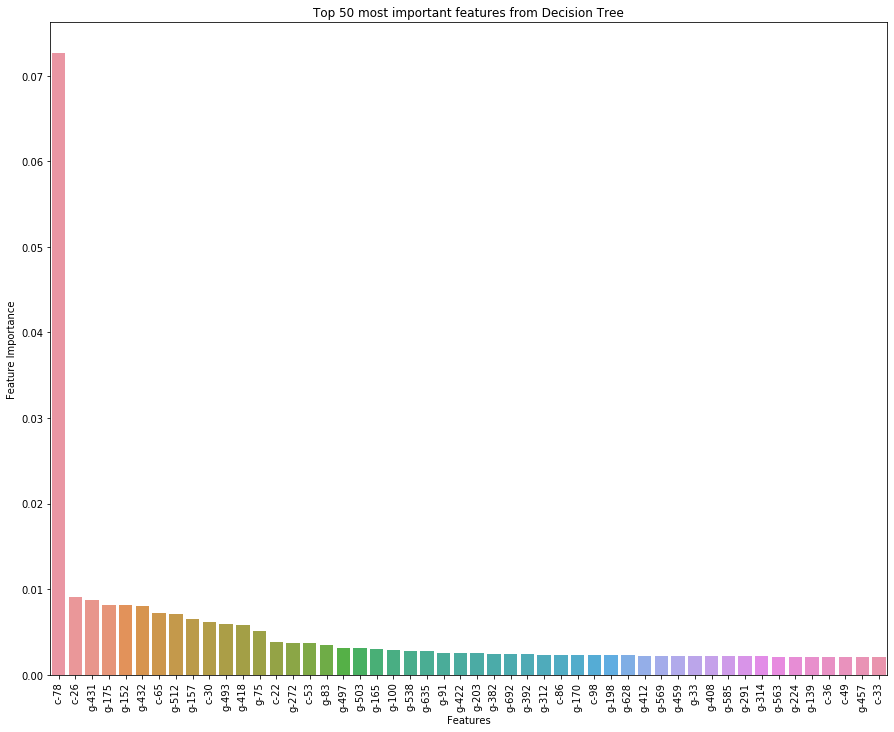

In [13]:
columns = train_features_df.columns
top50_most_important_columns = columns[dt_feature_importance_ind][:50]

fig, ax = plt.subplots(figsize=(15,12))
ax = sns.barplot(x=top50_most_important_columns, y=dt_feature_importance_val[:50])
ax.set_title(label='Top 50 most important features from Decision Tree')
ax.set_xlabel(xlabel='Features',)
ax.set_ylabel(ylabel='Feature Importance',)
plt.xticks(rotation=90)

plt.savefig(fname='top_50_importance.png')

## Predict

In [14]:
# y_train_predict = dt.predict(train_features_df)
# train_accuracy = accuracy_score(train_labels_df, y_train_predict)

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200,
    criterion='entropy',
    max_depth=6,
    min_samples_split=100,
    min_samples_leaf=30,
    max_features='sqrt',
    min_impurity_decrease=0.0,
#     min_impurity_split=0.01,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,)

rf.fit(train_features_df, train_labels_df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 17.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=1,
                       warm_start=False)

In [24]:
# fig, ax = plt.subplots(figsize=(15,12))
rf.feature_importances_

rf_feature_importance = rf.feature_importances_

rf_ranked_importance = np.argsort(rf_feature_importance)
rf_ranked_importance_ind = rf_ranked_importance[::-1] # Descending order
rf_ranked_importance_val = rf_feature_importance[rf_ranked_importance_ind]
np.save(file='rf_feature_importance_ranked_value', arr=rf_ranked_importance_val)
np.save(file='rf_feature_importance_ranked_ind', arr=rf_ranked_importance_ind)

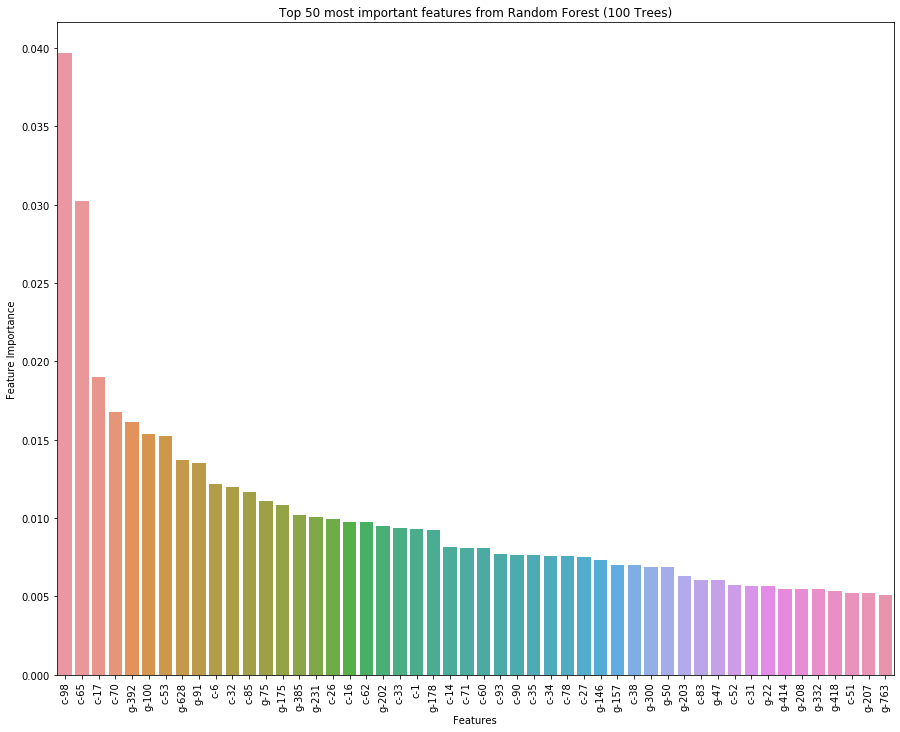

In [25]:
columns = train_features_df.columns
top50_most_important_columns = columns[rf_ranked_importance_ind][:50]

fig, ax = plt.subplots(figsize=(15,12))
ax = sns.barplot(x=top50_most_important_columns, y=rf_ranked_importance_val[:50])
ax.set_title(label='Top 50 most important features from Random Forest (100 Trees)')
ax.set_xlabel(xlabel='Features',)
ax.set_ylabel(ylabel='Feature Importance',)
plt.xticks(rotation=90)

plt.savefig(fname='rf_top_50_importance.png')

In [26]:
y_train_rf_predict = rf.predict(train_features_df)
train_accuracy = accuracy_score(train_labels_df, y_train_rf_predict)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   41.1s finished


In [27]:
train_accuracy

# First try - 0.3753
# Second Try - 0.3816
# Third - 0.3877 
# Fourth (random forest) - 0.38928 

0.3892837616183707

In [28]:
rf.oob_score_

0.9966394531823675